# NIRSpec MOS slits to sky

This notebook demonstrates how to map NIRSpec MSA slits to the sky and back.
We also show how to extract the wavelength grid from either the `S2D` or `X1D` pipeline products.

We use the [ERO 2736](https://www.stsci.edu/cgi-bin/get-proposal-info?observatory=JWST&id=2736) 
observations of SMACS0723, source 6355 (z = 7.665).

Inputs: 
* NIRSpec S2D file for this object from `Spec3Pipeline`
* NIRSpec MSA metafile
* NIRCam image from the [DJA](https://dawn-cph.github.io/dja/index.html)
* (optional) NIRCam color image produced using [Trilogy](https://github.com/dancoe/trilogy)
    * alternatively, you could show a single filter image in grayscale

# Import Libraries <a id='import'></a>

In [1]:
import os
home = os.path.expanduser("~")
from glob import glob
import numpy as np
from astropy.io import fits

In [2]:
from astropy.table import Table, vstack, unique

In [3]:
from jwst import datamodels

In [4]:
# To plot and view results

import matplotlib # as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 14})  # 18

from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import matplotlib.patheffects as pe # https://stackoverflow.com/questions/25426599/matplotlib-how-to-buffer-label-text

from astropy.visualization import simple_norm, ImageNormalize, AsinhStretch, ManualInterval, LogStretch, LinearStretch
from astropy.stats import sigma_clip, sigma_clipped_stats  # , SigmaClip

In [5]:
# Color image

import PIL
from PIL import Image, ImageEnhance
PIL.Image.MAX_IMAGE_PIXELS = 933120000  # allow it to load large image

In [6]:
import astropy
#import astropy.io.fits as pyfits
from astropy.io import fits
import astropy.wcs as wcs
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table, vstack, unique

# Helper Functions <a id='helper'></a>

In [7]:
def between(lo, x, hi):
    return (lo <= x) * (x <= hi)

def roundint(x):
    return int(np.round(x))

def slices_extent(x, y, dx, dy=0):
    dy = dy or dx
    xlo = roundint(x-dx)
    xhi = roundint(x+dx+1)
    ylo = roundint(y-dy)
    yhi = roundint(y+dy+1)
    xslice = slice(xlo, xhi)
    yslice = slice(ylo, yhi)
    slices = yslice, xslice
    extent = xlo, xhi, ylo, yhi
    return slices, extent

In [8]:
# Helper functions to select subset of files from list
def allin(elements, list_or_string):
    if type(elements) == str:
        elements = elements.split()
    for element in elements:
        if element not in list_or_string:
            return False
    return True

def anyin(elements, list_or_string):
    if type(elements) == str:
        elements = elements.split()
    for element in elements:
        if element in list_or_string:
            return True
    return False

# Select subset of files containing all search strings
def select_files(all_files, search_strings=[]):
    chosen_files = [file for file in all_files if allin(search_strings, file)]
    if len(chosen_files) == 1:
        chosen_files = chosen_files[0]
    return chosen_files    

# Select source

In [9]:
source_id = 6355  # z = 7.665

# Wavelength grid

### S2D model WCS transform –> RA, Dec, wavelength

https://jwst-pipeline.readthedocs.io/en/latest/_modules/jwst/assign_wcs/nirspec.html

In [10]:
spec3_output_dir = '../WCS/spec3'

s2d_files = glob(os.path.join(spec3_output_dir, '*_s2d.fits'))
s2d_file  = select_files(s2d_files, ['s%05d' % source_id])
s2d_file

'../WCS/spec3/jw02736-o007_s06355_nirspec_f290lp-g395m_s2d.fits'

In [11]:
s2d_model = datamodels.open(s2d_file)
#s2d_model.info(max_rows=99999)  # show all contents
#s2d_data = s2d_model.data + 0

In [12]:
if 'slits' in list(s2d_model):  # s2d has all the objects; extract the one with source_id
    source_ids = [slit.source_id for slit in s2d_model.slits]
    i_slit = source_ids.index(source_id)
    slit_model = s2d_model.slits[i_slit]
else:  # s2d only has one object
    slit_model = s2d_model
    i_slit = 0

s2d_data = slit_model.data + 0  # load and make copy
s2d_data = np.where(slit_model.err, s2d_data, np.nan)  # Replace zeros with nan where there is no data

In [13]:
slit_wcs = s2d_model.meta.wcs
y, x = np.mgrid[:s2d_data.shape[0], :s2d_data.shape[1]] # grid of pixel x,y indices 
det2sky = slit_wcs.get_transform('detector', 'world') # coordinate transform from detector pixels to sky 
ra, dec, s2d_waves = det2sky(x, y) # RA, Dec, wavelength (microns) for each pixel 
s2d_wave = s2d_waves[0, :] # only need a single row of values since this is the rectified spectrum 

In [14]:
s2d_wave

array([2.84863722, 2.85043148, 2.85222575, ..., 5.28289045, 5.28467829,
       5.28646621])

### can also read wavelength grid from x1d file

In [15]:
# Load 1D extraction
x1d_file = s2d_file.replace('s2d', 'x1d')
print(x1d_file)
x1d_model = datamodels.open(x1d_file)
#x1d_model.info(max_rows=99999)  # show all contents

../WCS/spec3/jw02736-o007_s06355_nirspec_f290lp-g395m_x1d.fits


In [16]:
x1d_wave = x1d_model.spec[i_slit].spec_table.WAVELENGTH

In [17]:
x1d_wave

array([2.84863722, 2.85043148, 2.85222575, ..., 5.28289045, 5.28467829,
       5.28646621])

### They're identical

In [18]:
s2d_wave - x1d_wave

array([-4.4408921e-16, -4.4408921e-16,  4.4408921e-16, ...,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00])

In [19]:
np.max(np.abs(s2d_wave - x1d_wave))

8.881784197001252e-16

# Metafile

In [20]:
msa_metafile = fits.getval(s2d_file, 'MSAMETFL')
#msa_metafile = download_jwst_files([msa_metafile], './')[0]
msa_metafile

'jw02736007001_01_msa.fits'

In [21]:
msa_hdu_list = fits.open(msa_metafile)
msa_hdu_list.info()

Filename: jw02736007001_01_msa.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   ()      
  1  SHUTTER_IMAGE    1 ImageHDU         8   (342, 730)   int16   
  2  SHUTTER_INFO    1 BinTableHDU     33   1318R x 12C   [I, I, I, I, I, J, 1A, 6A, E, E, I, 1A]   
  3  SOURCE_INFO    1 BinTableHDU     25   119R x 8C   [J, J, 20A, 31A, D, D, 30A, D]   


In [22]:
msa_hdu_list['SHUTTER_IMAGE'].data.shape

(730, 342)

In [23]:
shutter_table = Table(msa_hdu_list['SHUTTER_INFO'].data)
#shutter_table

In [24]:
set(shutter_table['msa_metadata_id'])  # Two MSA configs

{1, 76}

In [25]:
source_ids = set(shutter_table['source_id'])
source_ids = np.sort(list(source_ids))#.tolist()

In [26]:
source_table = Table(msa_hdu_list['SOURCE_INFO'].data)
select_source_table = source_table[source_table['source_id'] == source_id]
select_source_table

program,source_id,source_name,alias,ra,dec,preimage_id,stellarity
int32,int32,str20,str31,float64,float64,str30,float64
2736,6355,2736_6355,6355,110.84459416965377,-73.4350589621277,None,0.1


In [27]:
#source_ra, source_dec = 110.8446, -73.43506
source_ra  = select_source_table['ra'][0]
source_dec = select_source_table['dec'][0]
source_ra, source_dec

(110.84459416965377, -73.4350589621277)

In [28]:
shutter_table_dither1 = shutter_table[shutter_table['dither_point_index'] == 1]
shutter_table_dither1 = shutter_table_dither1[shutter_table_dither1['msa_metadata_id'] == 1]
source_select = [(id == source_id) for id in shutter_table_dither1['source_id']]
source_shutter_table = shutter_table_dither1[source_select]
source_shutter_table

slitlet_id,msa_metadata_id,shutter_quadrant,shutter_row,shutter_column,source_id,background,shutter_state,estimated_source_in_shutter_x,estimated_source_in_shutter_y,dither_point_index,primary_source
int16,int16,int16,int16,int16,int32,str1,str6,float32,float32,int16,str1
72,1,3,138,83,6355,Y,OPEN,nan,nan,1,N
72,1,3,138,84,6355,N,OPEN,0.46437824,0.86562544,1,Y
72,1,3,138,85,6355,Y,OPEN,nan,nan,1,N
72,1,3,138,86,6355,Y,OPEN,nan,nan,1,N
72,1,3,138,87,6355,Y,OPEN,nan,nan,1,N


In [29]:
i_primary = list(source_shutter_table['primary_source']).index('Y')
i_primary

1

# Color Image

Created with [Trilogy](https://github.com/dancoe/trilogy)
using [NIRCam images in the DAWN JWST Archive (DJA)](https://dawn-cph.github.io/dja/imaging/v7/)

In [30]:
color_image_file = '/Users/dcoe/SMACS0723/dja/v7/color/smacs0723_color_sw.png'  # Trilogy color image
im = Image.open(color_image_file)
im = im.transpose(method=Image.FLIP_TOP_BOTTOM)
color_image = np.asarray(im)
# Takes a few seconds to load a large image

In [31]:
fits_image_file = glob('/Users/dcoe/SMACS0723/dja/v7/images/20mas/*.fits')[0]  # DJA image reduction
fits_image_file  # for RA, Dec -> x, y

'/Users/dcoe/SMACS0723/dja/v7/images/20mas/smacs0723-grizli-v7.0-f200w-clear_drc_sci.fits'

In [32]:
color_image_hdulist = fits.open(fits_image_file)
idata = 0
image_wcs = wcs.WCS(color_image_hdulist[idata].header, color_image_hdulist)
image_wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 110.83403 -73.45429 
CRPIX : 9182.5 13030.5 
CD1_1 CD1_2  : -5.5555555555555e-06 0.0 
CD2_1 CD2_2  : 0.0 5.5555555555555e-06 
NAXIS : 24000  24000

# Define slit sizes

In [33]:
open_slit_x_size = 0.20  # open slit width  in arcseconds (dispersion direction)
open_slit_y_size = 0.46  # open slit height in arcseconds (cross-dispersion direction)

slit_bar_width   = 0.07

full_slit_x_size = open_slit_x_size + slit_bar_width
full_slit_y_size = open_slit_y_size + slit_bar_width
full_slit_x_size, full_slit_y_size

(0.27, 0.53)

https://jira.stsci.edu/browse/JP-1341

In [34]:
#x_scale, y_scale = 1.38, 1.16  # should read more precise values from MSA reference file?
#x_scale, y_scale = 1.35, 1.15  # better?
#x_scale, y_scale = 1.34, 1.14  # trying it

x_scale_open_to_full = full_slit_x_size / open_slit_x_size
y_scale_open_to_full = full_slit_y_size / open_slit_y_size
x_scale_open_to_full, y_scale_open_to_full

(1.35, 1.1521739130434783)

# Mapping Slits to the Sky

In [35]:
slit2sky = slit_wcs.get_transform('slit_frame', 'world')

In [36]:
# Slit corners in coordinates that range from (0,0) to (1,1)
open_slit_x_corners = 0, 0, 1, 1 
open_slit_y_corners = 0, 1, 1, 0

# Convert to origin at (0.5,0.5)
open_slit_x_corners = np.array(open_slit_x_corners) - 0.5
open_slit_y_corners = np.array(open_slit_y_corners) - 0.5

# Convert to full slit (not just open area)
full_slit_x_corners = x_scale_open_to_full * open_slit_x_corners
full_slit_y_corners = y_scale_open_to_full * open_slit_y_corners

In [37]:
#slitlet_ra, slitlet_dec, zero = slit2sky(x_corners, y_corners, 0)

In [38]:
# MSA metafile estimate of source position within shutter slitlet
# Coordinates range from (0,0) to (1,1)
estimated_source_in_shutter_x = source_shutter_table['estimated_source_in_shutter_x'][i_primary]
estimated_source_in_shutter_y = source_shutter_table['estimated_source_in_shutter_y'][i_primary]
estimated_source_in_shutter_x, estimated_source_in_shutter_y

(0.46437824, 0.86562544)

In [39]:
# Shift coordinate centroid to (0,0)
estimated_source_in_shutter_x -= 0.5
estimated_source_in_shutter_y -= 0.5

# Coordinates are actually for full slit (not just open area)
estimated_source_in_shutter_x *= x_scale_open_to_full
estimated_source_in_shutter_y *= y_scale_open_to_full

# Transform to sky (RA,Dec) using S2D WCS transformation
estimated_source_ra, estimated_source_dec, zero = slit2sky(
    estimated_source_in_shutter_x, estimated_source_in_shutter_y, 0)

# Transform to image pixels (x,y) using image WCS
estimated_source_coordinates = SkyCoord(ra=estimated_source_ra*u.deg, dec=estimated_source_dec*u.deg)
estimated_source_x, estimated_source_y = image_wcs.world_to_pixel(estimated_source_coordinates)

estimated_source_x, estimated_source_y

(array(8639.80466798), array(16485.56199579))

In [40]:
# Calculate offset between S2D WCS transformation and actual coordinates in input catalog
# The input catalog coordinates (RA,Dec) are more accurate than the pipeline (RA,Dec)
source_coordinates = SkyCoord(ra=source_ra*u.deg, dec=source_dec*u.deg)
source_xy = source_x, source_y = image_wcs.world_to_pixel(source_coordinates)

# We'll correct for this offset below
dx_obs = estimated_source_x - source_x
dy_obs = estimated_source_y - source_y

dx_obs, dy_obs

(0.44040891860095144, -5.477046126175992)

In [41]:
# Indices to iterate along slit with multiple shutters
# (e.g., dy_columns = -1,0,1 for 3-shutter slitlet)
dx_rows    = source_shutter_table['shutter_row']    - source_shutter_table['shutter_row'][i_primary]
dy_columns = source_shutter_table['shutter_column'] - source_shutter_table['shutter_column'][i_primary]

# Scale to full slit (not just open area)
dx_rows    = np.array(dx_rows)    * x_scale_open_to_full
dy_columns = np.array(dy_columns) * y_scale_open_to_full
# Note the cross-dispersion direction is defined as columns in the MSA metafile
# even though we normally show them as rows in the MSA
dy_columns  

array([-1.15217391,  0.        ,  1.15217391,  2.30434783,  3.45652174])

In [42]:
# Convert full slit corner coordinates to sky using S2D WCS transformation slit2sky
xx = []
yy = []

for i in range(len(dy_columns)):
    slitlet_ra, slitlet_dec, zero = slit2sky(full_slit_x_corners + dx_rows[i], full_slit_y_corners + dy_columns[i], 0)
    slit_coordinates = SkyCoord(ra=slitlet_ra*u.deg, dec=slitlet_dec*u.deg)
    xy = x, y = image_wcs.world_to_pixel(slit_coordinates)
    xx.append(x)
    yy.append(y)

# Define the image stamp region: a 3"x3" square around the center of the slits
dx = 75  # half-width in pixels (0.02" * 75 pixels = 1.5", so the image will be 3"x3")
slices, extent = slices_extent(np.mean(xx), np.mean(yy), dx)
xlo, xhi, ylo, yhi = extent
np.mean(xx), np.mean(yy)

(8626.327030078093, 16475.20981900441)

In [43]:
slit_color = (0.5,0.85,1)
slit_color = 'r'
source_color = (0,0.8,0)

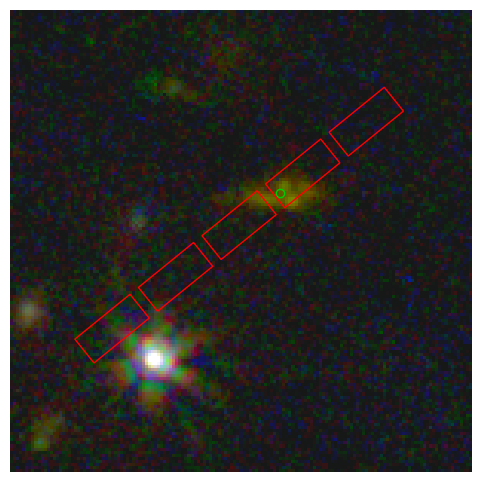

In [44]:
fig = plt.figure(figsize=(9.5, 6))
ax = fig.add_subplot(1, 1, 1) #, projection=imwcs) # , sharex=True, sharey=True)
ax.imshow(color_image[slices], extent=extent, origin='lower')

plt.plot(source_x, source_y, 'o', mec=source_color, mfc='None')

for i in range(len(source_shutter_table)):
    slitlet_ra, slitlet_dec, zero = slit2sky(open_slit_x_corners + dx_rows[i], open_slit_y_corners + dy_columns[i], 0)
    slit_coordinates = SkyCoord(ra=slitlet_ra*u.deg, dec=slitlet_dec*u.deg)
    xy = x, y = image_wcs.world_to_pixel(slit_coordinates)
    x -= dx_obs
    y -= dy_obs
    xy = np.array([x, y]).T
    patch = matplotlib.patches.Polygon(xy, fc='None', ec=slit_color, alpha=1, zorder=100)
    ax.add_patch(patch)

ax.axis('off')  # hide the axis coordinates, ticks, and labels
plt.show()

# Mapping Sky back to Slits

In [45]:
d_slit = 1  # number of shutters to extend in either direction
y_slit_lo = 0 - d_slit
y_slit_hi = 1 + d_slit

In [46]:
# Create a high-resolution coordinate grid in the slit plane
y_slit, x_slit = np.mgrid[y_slit_lo:y_slit_hi:1001j,0:1:1001j] - 0.5
x_slit *= x_scale_open_to_full
y_slit *= y_scale_open_to_full

# Transform these to the image plane
ra_slit, dec_slit, zero = slit2sky(x_slit, y_slit, 0)
coords_slit = SkyCoord(ra=ra_slit*u.deg, dec=dec_slit*u.deg)
x_image, y_image = image_wcs.world_to_pixel(coords_slit)

# Extract the image values (colors) at each coordinate
slit_stamp = color_image[np.round(y_image-dy_obs).astype(int), np.round(x_image-dx_obs).astype(int)]

In [47]:
xlo, xhi, ylo, yhi = slit_extent = x_slit[0,0], x_slit[0,-1], y_slit[0,0], y_slit[-1,0]
slit_extent

(-0.675, 0.675, -1.7282608695652173, 1.7282608695652173)

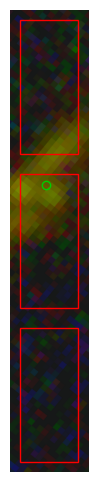

In [48]:
fig = plt.figure(figsize=(9.5, 6))
ax = fig.add_subplot(1, 1, 1) #, projection=imwcs) # , sharex=True, sharey=True)
ax.imshow(slit_stamp, origin='lower', aspect=open_slit_y_size/open_slit_x_size, extent=slit_extent)

for dy in -1,0,1:
    xy_corners = np.array([open_slit_x_corners, open_slit_y_corners+dy*y_scale_open_to_full]).T
    patch = matplotlib.patches.Polygon(xy_corners, fc='None', ec=slit_color, alpha=1, zorder=100)
    ax.add_patch(patch)
    
plt.plot(estimated_source_in_shutter_x, estimated_source_in_shutter_y, 'o', mec=source_color, mfc='None')

plt.axis('off');  # hide the axis coordinates, ticks, and labels